# Project Milestone 2 Pipeline
* That you can handle the data in its size.
* That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
* That you considered ways to enrich, filter, transform the data according to your needs.
* That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
* That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [49]:
class Data(Enum):
    MOVIES = "movie.metadata.tsv"
    PLOTS = "plot_summaries.txt"
    NAME_CLUSTERS = "name.clusters.txt"

def load_data(type : Data, columns, index_col = ""):
    return pd.read_csv(
        f'./rawdata/MovieSummaries/{type.value}', 
        sep="\t", 
        names=columns,
        index_col=index_col if index_col != "" else columns[0]
    )

movie_df = load_data(
    Data.MOVIES, 
    ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"],
)
plot_df = load_data(
    Data.PLOTS, 
    ["wiki_id", "plot"]
)
name_df = load_data(
    Data.NAME_CLUSTERS, 
    ["character_name", "freebase_id"],
    index_col="freebase_id"
)

## Basic Data Cleaning

In [50]:
import re

# Parses the multi value structure of the dataset format into a sorted array of items
# Returns null values for empty lists as NaN (so all missing values we use are NaN)
def parse_multi_values(x): 
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

# Add plot summaries to the movie df
movie_df = movie_df.join(plot_df)

# Parses the language column specifically by removing "Langauge" from each entry
def parse_language(languages):
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

# Parses the date format into an int representing only the year. Values with missing entries are given NaN.
def parse_date(x):
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

# Parse multi value attributes into arrays
for attribute in ["languages", "countries", "genres"]:
    movie_df[attribute] = movie_df[attribute].apply(parse_multi_values)

# Remove "Language" from language column
movie_df["languages"] = movie_df["languages"].apply(parse_language)

# Parse release-date to all use the year as an int (don't need increased granularity right now)
movie_df["release_date"] = movie_df["release_date"].apply(parse_date)

# Replace missing numeric values with zero and convert to int rather than float
for col in ["runtime", "revenue"]:
    movie_df[col] = movie_df[col].fillna(0)
    movie_df[col] = movie_df[col].astype(int)

movie_df


,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832,98,[English],[United States of America],"[Action, Adventure, Horror, Science Fiction, S...","Set in the second half of the 22nd century, th..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,0,95,[English],[United States of America],"[Biographical film, Crime Drama, Drama, Mystery]",NaN
28463795,/m/0crgdbh,Brun bitter,1988,0,83,[Norwegian],[Norway],"[Crime Fiction, Drama]",NaN
9363483,/m/0285_cd,White Of The Eye,1987,0,110,[English],[United Kingdom],"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
261236,/m/01mrr1,A Woman in Flames,1983,0,106,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
...,...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,0,120,[English],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...
34980460,/m/0g4pl34,Knuckle,2011,0,96,[English],"[Ireland, United Kingdom]","[Biographical film, Documentary, Drama]",{{No plot}} This film follows 12 years in the ...
9971909,/m/02pygw1,Another Nice Mess,1972,0,66,[English],[United States of America],"[Comedy, Satire]",NaN


## Analyzing missing values

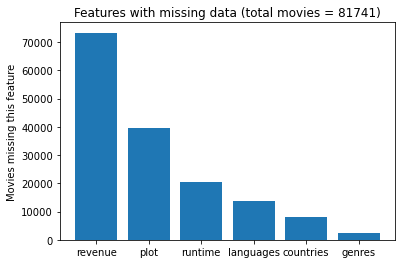

Rows without any missing data is 42204


In [59]:
# Let's check to what extent we have missing data
# For each column, count the number of missing data and plot a bar graph
def analyze_missing_values(df : pd.DataFrame): 
    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        # Missing are na or empty falsy values such as empty lists
        num_missing = df[col].isna().sum() + (df[col].astype(bool) == False).sum()
        if num_missing > 0:
            missing[col] = num_missing
    missing = sorted(missing.items(), key=lambda x: x[1], reverse=True)
    plt.bar(
        list(map(lambda x : x[0], missing)), 
        list(map(lambda x : x[1], missing)),
    )
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

    # Count how many rows are without any missing values
    non_missing = (df.notnull().all(axis="columns") == True).sum()
    print("Rows without any missing data is", non_missing)

analyze_missing_values(movie_df)

## Basic data analysis 

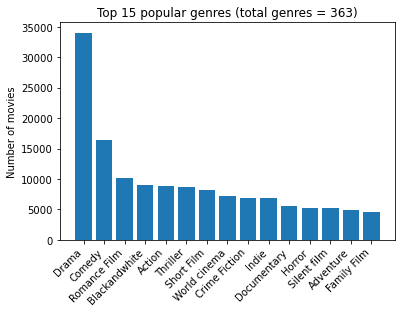

118 of movies have genre's that only occurr 20 times in the dataset


In [25]:
# Let's plot the popularity of genres over time 
# Y-axis being number of movies and genres 

# Function that maps a list of items in a series 
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Let's plot the top genres
genres = to_1D(movie_df["genres"]).value_counts()
top_k = 15
top_genres = genres.head(n=top_k)
plt.bar(top_genres.index, top_genres.values)
plt.title(f"Top {top_k} popular genres (total genres = {len(genres)})")
plt.ylabel("Number of movies")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

obscure_threshold = 20
obscure_genres = genres[genres <= obscure_threshold]
print(f"{len(obscure_genres)} of movies have genre's that only occurr {obscure_threshold} times in the dataset")


## Cleaning up "release_date"

In [26]:

movie_count = movie_df.groupby("release_date").count()["wiki_id"]
movie_count = movie_count.dropna()
movie_count = movie_count.sort_values()[1:-1]
movie_count.describe()

KeyError: 'wiki_id'